In [98]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# Warum auch immer, bekomme ich einen fehler wenn ich das hier nicht drinne habe. 
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [99]:
# Die wollen English - Spanish, ich will aber deutsch >:
path_to_file = "E:/GitHub Repos/TensorFlow training//deu-eng/deu.txt"

In [100]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # Punctuation soll auch space haben
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # abfangen von allen anderen, damit es spaces sind
    # w = re.sub(r"[^a-zA-Z?.!,¿öäüÖÄÜß]+", " ", w)
    
    w = w.strip()
    
    w = '<start> ' + w + ' <end>'
    return w

In [101]:
en_sentence = u"May I borrow this book?"
de_sentence = u"Darf ich mir dieses Buch ausleihen?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(de_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> darf ich mir dieses buch ausleihen ? <end>'


In [102]:
# Aufräumen
# In Paaren zurückgeben

def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[0:2]]  for l in lines[:num_examples]] # hier musste ich haxorn, da in den OG daten noch mehr steht, was wir nicht brauchen
    return zip(*word_pairs)


en, de = create_dataset(path_to_file, None)
print(en[-1])
print(de[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa; but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> ohne zweifel findet sich auf dieser welt zu jedem mann genau die richtige ehefrau und umgekehrt; wenn man jedoch in betracht zieht , dass ein mensch nur gelegenheit hat , mit ein paar hundert anderen bekannt zu sein , von denen ihm nur ein dutzend oder weniger nahesteht , darunter hochstens ein oder zwei freunde , dann erahnt man eingedenk der millionen einwohner dieser welt leicht , dass seit erschaffung ebenderselben wohl noc

In [103]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, lang_tokenizer 

In [104]:
def load_dataset(path, num_examples=None):
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [105]:
# Das trainieren kann JAHRE dauern, daher fixen
num_examples = 120000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [106]:
# Training & Validation split 80/20
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

96000 96000 24000 24000


In [107]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))
            
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
13 ----> es
7 ----> ist
9 ----> nicht
56 ----> so
335 ----> schwer
8 ----> ,
32 ----> wie
12 ----> du
429 ----> denkst
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
46 ----> it's
36 ----> not
98 ----> as
239 ----> hard
98 ----> as
6 ----> you
54 ----> think
3 ----> .
2 ----> <end>


In [108]:
# Damit wir damit besser in TF arbeiten können, umwandeln in ein TF.data Dataset

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [109]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 23]), TensorShape([64, 16]))

In [110]:
# Creating a custom attention Model. Wir haben ein Encoder, Decoder und unser BahdanauAttention Layer:

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [111]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 23, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [112]:
# Copy of the Attention Model:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [113]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 23, 1)


In [114]:
# Decoder Copy
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [115]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 10435)


In [116]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [117]:
checkpoint_dir = './att2_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [118]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [119]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
            
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.9125
Epoch 1 Batch 100 Loss 1.8963
Epoch 1 Batch 200 Loss 1.8093
Epoch 1 Batch 300 Loss 1.7459
Epoch 1 Batch 400 Loss 1.6722
Epoch 1 Batch 500 Loss 1.4862
Epoch 1 Batch 600 Loss 1.3901
Epoch 1 Batch 700 Loss 1.2431
Epoch 1 Batch 800 Loss 1.1716
Epoch 1 Batch 900 Loss 1.2682
Epoch 1 Batch 1000 Loss 1.1242
Epoch 1 Batch 1100 Loss 1.2207
Epoch 1 Batch 1200 Loss 1.1870
Epoch 1 Batch 1300 Loss 1.0821
Epoch 1 Batch 1400 Loss 0.9571
Epoch 1 Loss 1.4128
Time taken for 1 epoch 263.6188852787018 sec

Epoch 2 Batch 0 Loss 0.9464
Epoch 2 Batch 100 Loss 1.0445
Epoch 2 Batch 200 Loss 0.9565
Epoch 2 Batch 300 Loss 0.9551
Epoch 2 Batch 400 Loss 0.8088
Epoch 2 Batch 500 Loss 0.8031
Epoch 2 Batch 600 Loss 0.8112
Epoch 2 Batch 700 Loss 0.8584
Epoch 2 Batch 800 Loss 0.7529
Epoch 2 Batch 900 Loss 0.6964
Epoch 2 Batch 1000 Loss 0.6060
Epoch 2 Batch 1100 Loss 0.7426
Epoch 2 Batch 1200 Loss 0.6784
Epoch 2 Batch 1300 Loss 0.6885
Epoch 2 Batch 1400 Loss 0.6954
Epoch 2 Loss 0.7969
Time tak

In [120]:
# Copy & Paste der evaluation & plotting
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hallo wie geht es dir ? <end>
Predicted translation: how are you ? <end> 


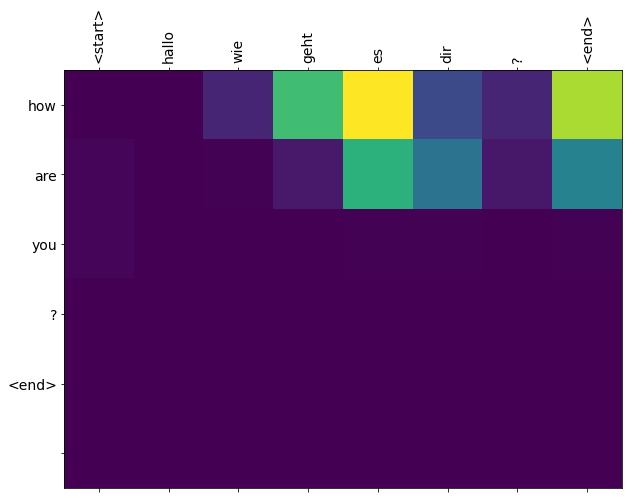

In [67]:
# Ergebnis mit dem alten Modell auf 30k Inputs
translate(u'Hallo wie geht es dir?')

Input: <start> es ist sehr kalt hier <end>
Predicted translation: it s cold now . <end> 


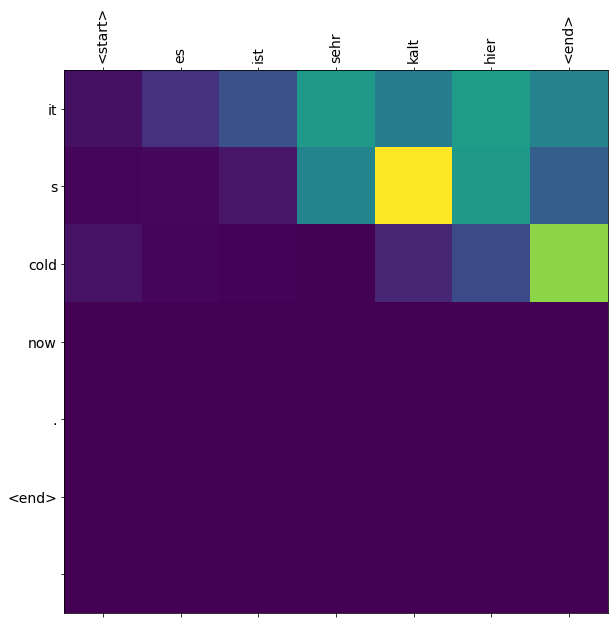

In [68]:
# Ergebnis mit dem alten Modell auf 30k Inputs
translate(u'es ist sehr kalt hier') # falsch, hier != now

Input: <start> alle kinder spielen gerne fußball <end>
Predicted translation: how kids like soccer . <end> 


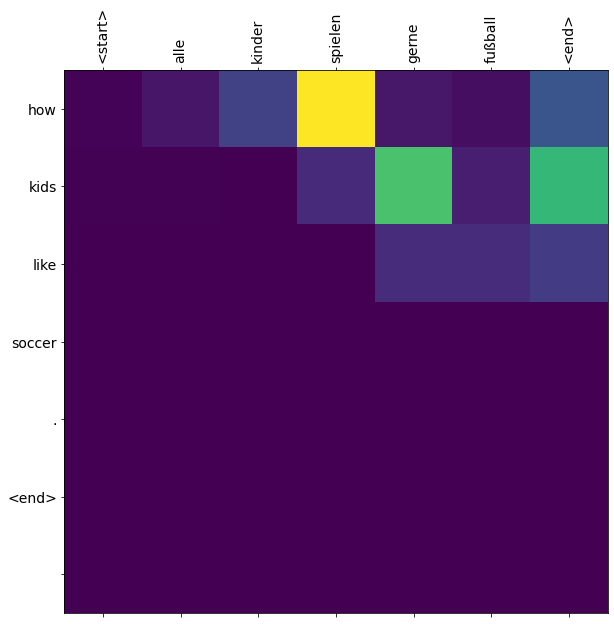

In [70]:
# Ergebnis mit dem alten Modell auf 30k Inputs
translate(u'Alle Kinder spielen gerne Fußball')

Input: <start> hallo junge , wie geht es dir ? <end>
Predicted translation: what s life ? <end> 


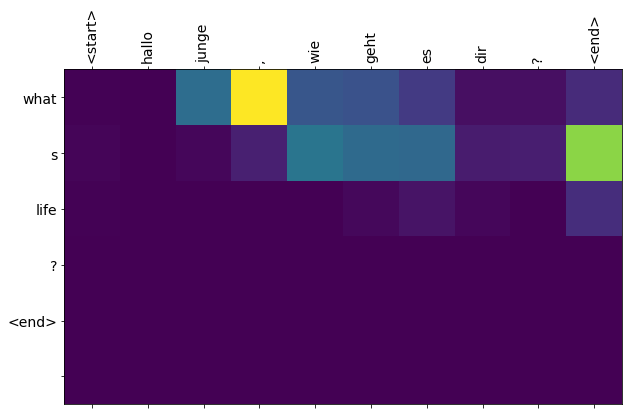

In [76]:
# Ergebnis mit dem alten Modell auf 30k Inputs
translate(u'Hallo Junge, wie geht es dir?')

Input: <start> hallo junge , wie geht es dir ? <end>
Predicted translation: who looks after you ? <end> 


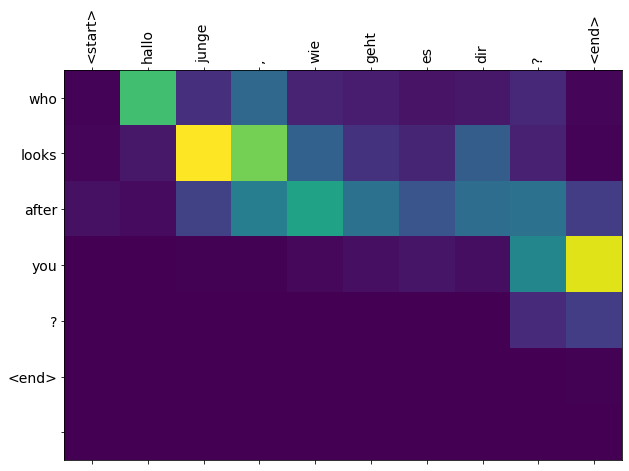

In [121]:
# Ab hier mit den 120k Inputs:
translate(u'Hallo Junge, wie geht es dir?')

Input: <start> alle kinder spielen gerne fußball <end>
Predicted translation: all the dogs like playing bridge . <end> 


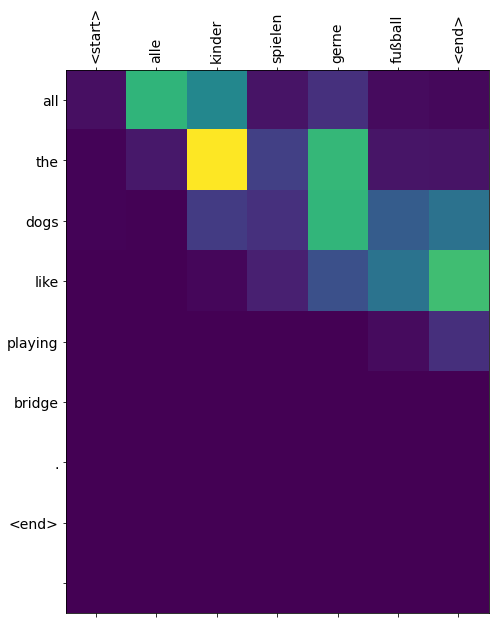

In [122]:
translate(u'Alle Kinder spielen gerne Fußball')

Input: <start> es ist sehr kalt hier <end>
Predicted translation: it's very cold here . <end> 


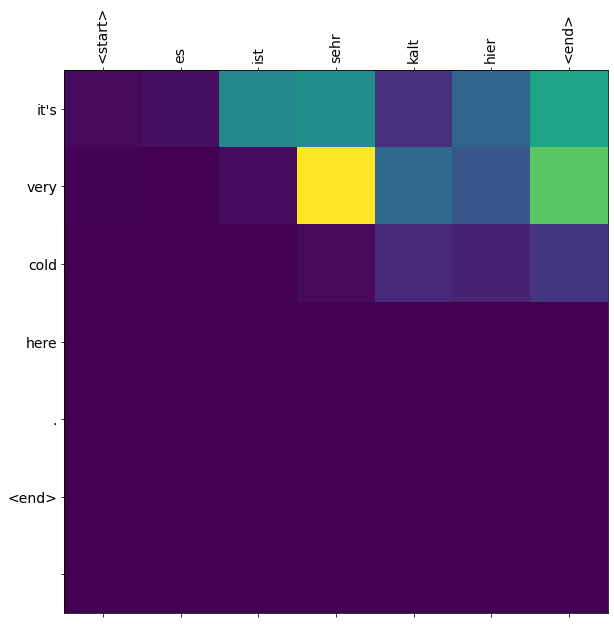

In [123]:
translate(u'es ist sehr kalt hier') # <- Einzige das wirklich besser geworden ist. Die anderen sind doch schlimmer geworden.

Input: <start> heute ist ein sehr schoner tag . ich freue mich schon darauf viel zu unternehmen und noch mehr satze zu ubersetzen <end>
Predicted translation: i'm very busy day . <end> 


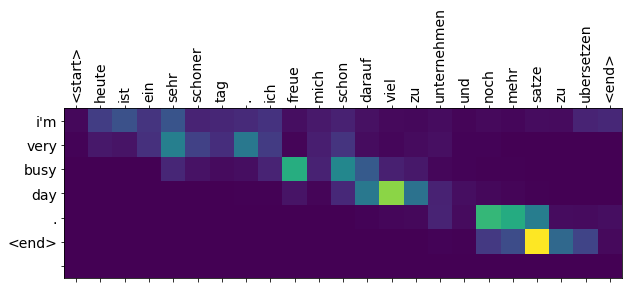

In [126]:
translate(u'Heute ist ein sehr schöner Tag. Ich freue mich schon darauf viel zu unternehmen und noch mehr Sätze zu übersetzen')

Input: <start> ist es besser bei kurzen tests ? <end>
Predicted translation: is it even cold before ? <end> 


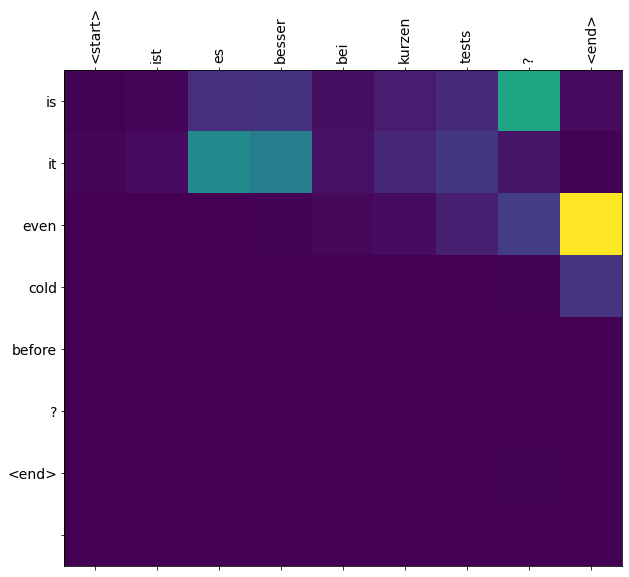

In [129]:
translate(u'Ist es besser bei kurzen tests?')

Input: <start> wir haben da immer stunden verbracht . <end>
Predicted translation: we used to spend hours there . <end> 


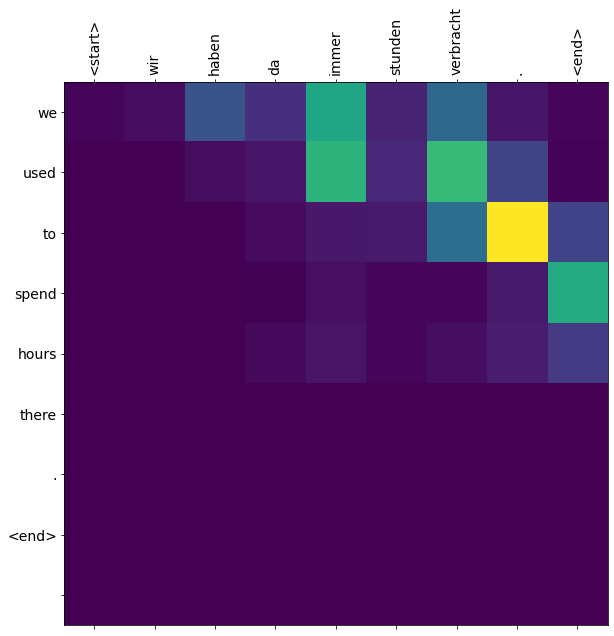

In [132]:
translate(u'Wir haben da immer Stunden verbracht.')

Input: <start> wir haben da immer stunden fur gebraucht . <end>
Predicted translation: we used to spend hours there . <end> 


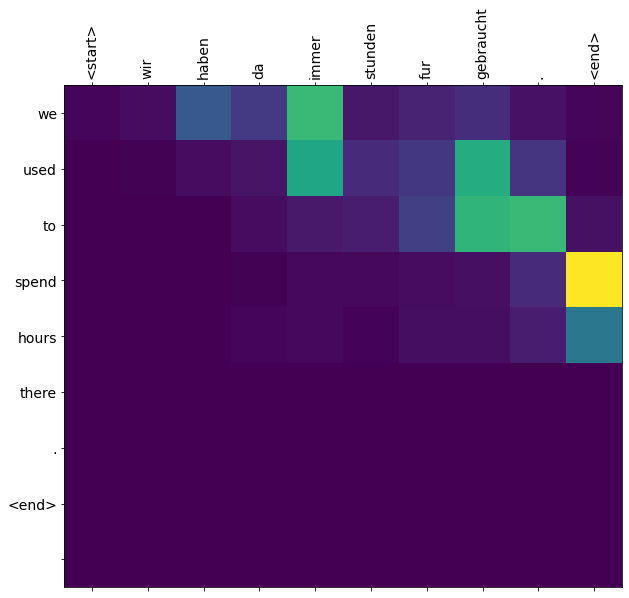

In [134]:
translate(u'Wir haben da immer Stunden für gebraucht.')

Input: <start> ich habe da immer stunden gewartet . <end>
Predicted translation: i've waited for hours there . <end> 


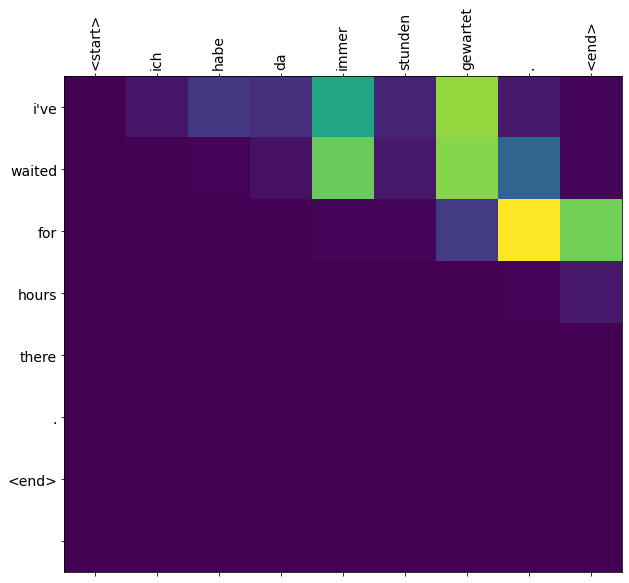

In [135]:
translate(u'Ich habe da immer Stunden gewartet.')

Input: <start> es mussten mehrere stunden vergehen , ehe ich verstand was ich da mache <end>
Predicted translation: some few people have to be done . <end> 


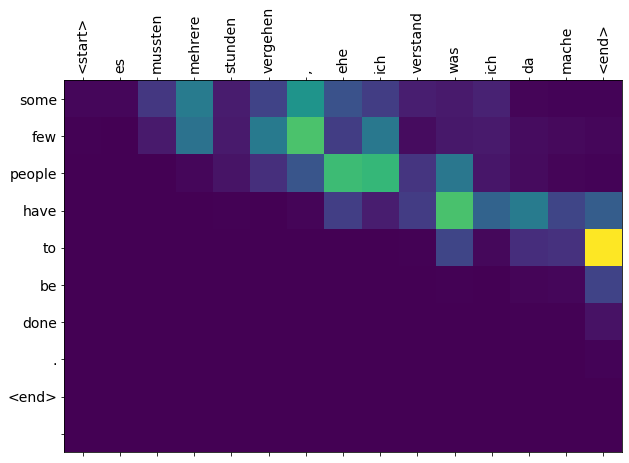

In [137]:
translate(u'Es mussten mehrere Stunden vergehen, ehe ich verstand was ich da mache')

Input: <start> ich hore gerne laute musik . <end>
Predicted translation: i like to speak to girls . <end> 


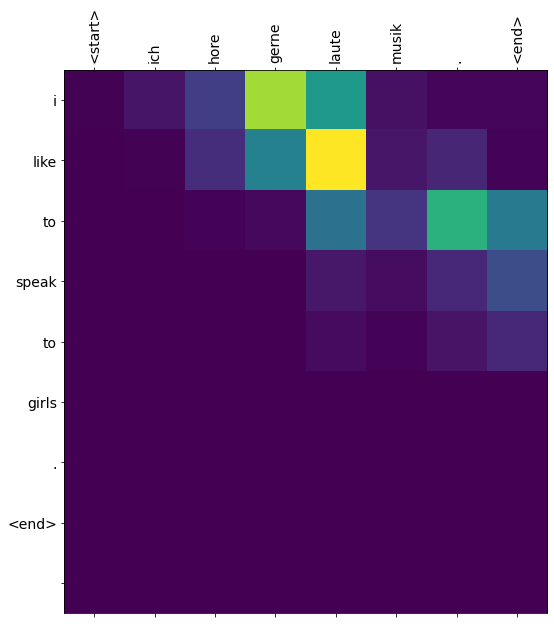

In [145]:
translate(u'Ich höre gerne laute Musik.') # <- BESTE!!!

Input: <start> ich spreche gerne zu frauen . <end>
Predicted translation: i like to meet women . <end> 


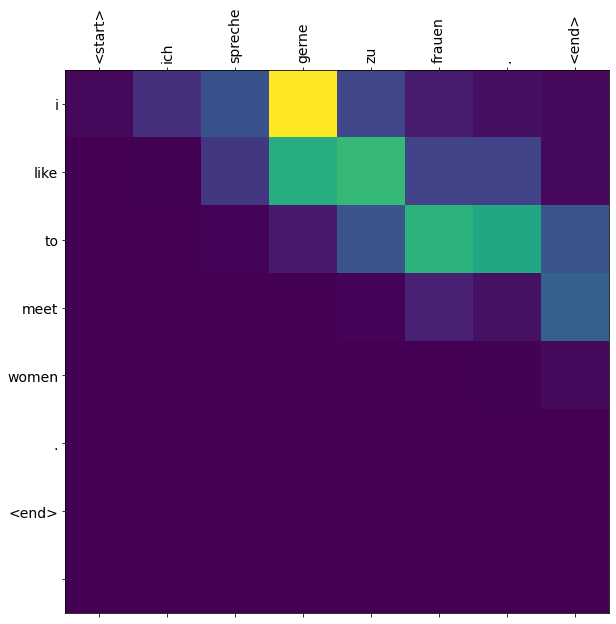

In [147]:
translate(u'Ich spreche gerne zu frauen.') # <- das geht hier in eine GANZ komische Richtung